In [ ]:
from pathlib import Path
from drone_detector.tiling import *
import os, sys
import geopandas as gpd
import pandas as pd
import rasterio as rio
import math
from shapely.geometry import box

In [ ]:
from shapely.geometry import Polygon
def fix_multipolys(multipoly):
    temp_poly = None
    max_area = 0
    for geom in multipoly.geoms:
        area = geom.area
        if area > max_area:
            max_area = area
            temp_poly = geom
    return Polygon(temp_poly.exterior)

In [ ]:
from shapely.geometry import Point 

def get_len(geom):
    mrr = geom.minimum_rotated_rectangle
    x, y = mrr.exterior.coords.xy
    edge_len = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))
    return max(edge_len)

In [ ]:
data_path = Path('../data/hiidenportti/resnet50_valsplit/label_nms/eval_results')

# Ground Truths (TP/FN) -comparison

In [ ]:
gts = gpd.read_file(data_path/'gts.geojson')

In [ ]:
fns = gts[gts.det_type == 'FN'].copy()
gt_tps = gts[gts.det_type == 'TP'].copy()

## False negatives

In [ ]:
fns['geometry'] = fns.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                        else Polygon(row.geometry.exterior), axis=1)
fns['area'] = fns.geometry.area
fns['pixel_area'] = fns.area / 0.04**2
fns['bbox_area'] = fns.apply(lambda row: box(*row.geometry.bounds).area, axis=1)
fns['bbox_x_px'] = fns.apply(lambda row: (row.geometry.bounds[2] - row.geometry.bounds[0]) / 0.04, axis=1)
fns['bbox_y_px'] = fns.apply(lambda row: (row.geometry.bounds[3] - row.geometry.bounds[1]) / 0.04, axis=1)
fns['bbox_pixel_area'] = fns.bbox_area / 0.04**2
fns['bbox_aspect_ratio'] = fns.bbox_x_px / fns.bbox_y_px
fns['length'] = fns.apply(lambda row: get_len(row.geometry), axis=1)

In [ ]:
pd.pivot_table(fns, index='tree_type', values='area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,area,area,area,area
tree_type,,,,
Fallen,0.059014,2.543199,0.343440,0.254789
Standing,0.573524,5.957790,2.396268,1.926845
All,0.059014,5.957790,0.440706,0.261347


In [ ]:
pd.pivot_table(fns, index='tree_type', values='pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,pixel_area,pixel_area,pixel_area,pixel_area
tree_type,,,,
Fallen,36.883581,1589.499644,214.650020,159.243398
Standing,358.452805,3723.618546,1497.667689,1204.278197
All,36.883581,3723.618546,275.441381,163.341574


In [ ]:
pd.pivot_table(fns, index='tree_type', values='bbox_pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_pixel_area,bbox_pixel_area,bbox_pixel_area,bbox_pixel_area
tree_type,,,,
Fallen,42.152664,19419.003403,1265.528811,585.729383
Standing,499.902485,5908.502863,2530.811431,1848.475637
All,42.152664,19419.003403,1325.479858,620.580889


In [ ]:
pd.pivot_table(fns, index='tree_type', values='bbox_aspect_ratio', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_aspect_ratio,bbox_aspect_ratio,bbox_aspect_ratio,bbox_aspect_ratio
tree_type,,,,
Fallen,0.067227,9.600000,1.601919,1.005155
Standing,0.720588,1.558824,1.064416,0.941176
All,0.067227,9.600000,1.576452,1.000000


In [ ]:
pd.pivot_table(fns, index='tree_type', values='bbox_x_px', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_x_px,bbox_x_px,bbox_x_px,bbox_x_px
tree_type,,,,
Fallen,3.246254,230.921473,33.881817,26.762980
Standing,21.317993,73.470344,48.485916,49.627860
All,3.246254,230.921473,34.573782,27.052118


<AxesSubplot:title={'center':'Distribution of bounding box width, in pixels'}, ylabel='Frequency'>

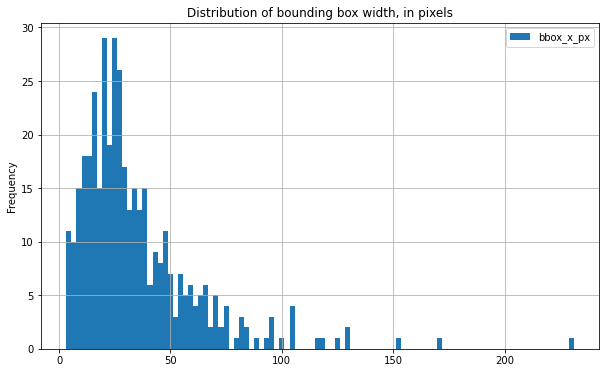

In [ ]:
fns.plot(kind='hist', y='bbox_x_px', bins=100, grid=True, 
         title='Distribution of bounding box width, in pixels',
         figsize=(10,6))

In [ ]:
pd.pivot_table(fns, index='tree_type', values='bbox_y_px', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_y_px,bbox_y_px,bbox_y_px,bbox_y_px
tree_type,,,,
Fallen,3.246254,195.589971,30.733143,24.568816
Standing,21.641694,81.156354,47.524212,42.201304
All,3.246254,195.589971,31.528729,24.887949


<AxesSubplot:title={'center':'Distribution of bounding box width, in pixels'}, ylabel='Frequency'>

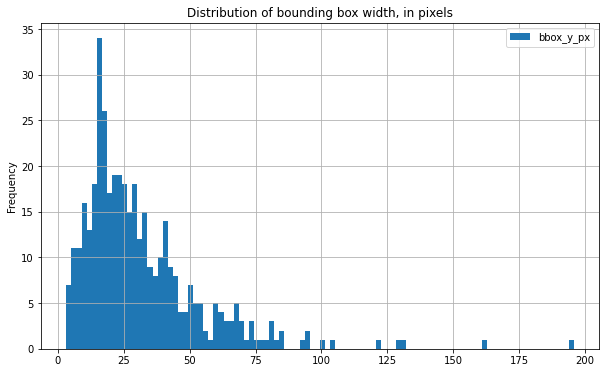

In [ ]:
fns.plot(kind='hist', y='bbox_y_px', bins=100, grid=True, 
         title='Distribution of bounding box width, in pixels',
         figsize=(10,6))

In [ ]:
pd.pivot_table(fns, index='tree_type', values='length', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,length,length,length,length
tree_type,,,,
Fallen,0.476117,9.788488,1.904225,1.554527
Standing,1.078615,3.338757,2.055404,1.874621
All,0.476117,9.788488,1.911388,1.574674


<AxesSubplot:title={'center':'Distribution of groundwood length in meters'}, ylabel='Frequency'>

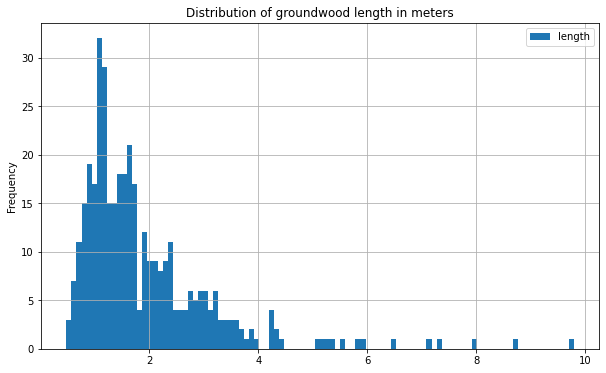

In [ ]:
fns[fns.tree_type =='Fallen'].plot(kind='hist', y='length', bins=100, grid=True, 
                                   title='Distribution of groundwood length in meters',
                                   figsize=(10,6))

<AxesSubplot:title={'center':'Distribution of uprightwood maximum canopy diameter, in meters'}, ylabel='Frequency'>

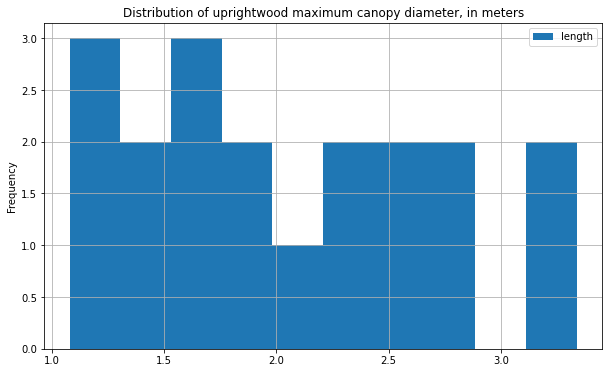

In [ ]:
fns[fns.tree_type =='Standing'].plot(kind='hist', y='length', bins=10, grid=True, 
                                     title='Distribution of uprightwood maximum canopy diameter, in meters',
                                     figsize=(10,6))

## True positives

In [ ]:
gt_tps['geometry'] = gt_tps.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                        else Polygon(row.geometry.exterior), axis=1)
gt_tps['area'] = gt_tps.geometry.area
gt_tps['pixel_area'] = gt_tps.area / 0.04**2
gt_tps['bbox_area'] = gt_tps.apply(lambda row: box(*row.geometry.bounds).area, axis=1)
gt_tps['bbox_x_px'] = gt_tps.apply(lambda row: (row.geometry.bounds[2] - row.geometry.bounds[0]) / 0.04, axis=1)
gt_tps['bbox_y_px'] = gt_tps.apply(lambda row: (row.geometry.bounds[3] - row.geometry.bounds[1]) / 0.04, axis=1)
gt_tps['bbox_pixel_area'] = gt_tps.bbox_area / 0.04**2
gt_tps['bbox_aspect_ratio'] = gt_tps.bbox_x_px / gt_tps.bbox_y_px
gt_tps['length'] = gt_tps.apply(lambda row: get_len(row.geometry), axis=1)

In [ ]:
pd.pivot_table(gt_tps, index='tree_type', values='area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,area,area,area,area
tree_type,,,,
Fallen,0.063260,2.852041,0.477244,0.399013
Standing,0.355334,10.790502,3.647911,2.990839
All,0.063260,10.790502,0.878594,0.436090


In [ ]:
pd.pivot_table(gt_tps, index='tree_type', values='pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,pixel_area,pixel_area,pixel_area,pixel_area
tree_type,,,,
Fallen,39.537392,1782.525543,298.277523,249.383172
Standing,222.083782,6744.063860,2279.944313,1869.274139
All,39.537392,6744.063860,549.121420,272.556063


In [ ]:
pd.pivot_table(gt_tps, index='tree_type', values='bbox_pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_pixel_area,bbox_pixel_area,bbox_pixel_area,bbox_pixel_area
tree_type,,,,
Fallen,61.884613,32984.498867,1888.173147,1094.167197
Standing,332.356330,11797.321883,3931.946412,3271.943724
All,61.884613,32984.498867,2146.878623,1284.678729


In [ ]:
pd.pivot_table(gt_tps, index='tree_type', values='bbox_aspect_ratio', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_aspect_ratio,bbox_aspect_ratio,bbox_aspect_ratio,bbox_aspect_ratio
tree_type,,,,
Fallen,0.055215,28.4,1.882766,1.070175
Standing,0.683333,1.6,1.065148,1.033009
All,0.055215,28.4,1.779270,1.055556


In [ ]:
pd.pivot_table(gt_tps, index='tree_type', values='bbox_x_px', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_x_px,bbox_x_px,bbox_x_px,bbox_x_px
tree_type,,,,
Fallen,4.328339,274.472453,45.224531,37.468172
Standing,18.230643,120.362575,60.846953,55.741260
All,4.328339,274.472453,47.202053,40.512539


<AxesSubplot:title={'center':'Distribution of bounding box width, in pixels'}, ylabel='Frequency'>

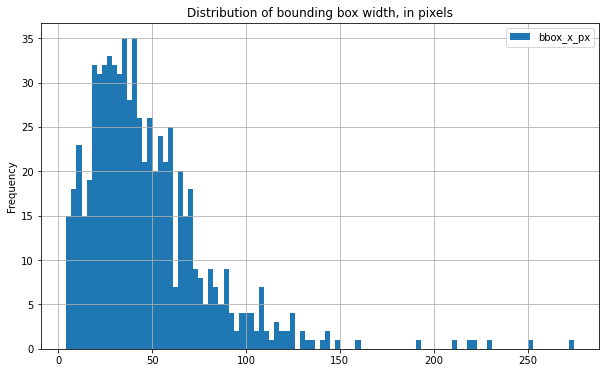

In [ ]:
gt_tps.plot(kind='hist', y='bbox_x_px', bins=100, grid=True, 
         title='Distribution of bounding box width, in pixels',
         figsize=(10,6))

In [ ]:
pd.pivot_table(gt_tps, index='tree_type', values='bbox_y_px', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_y_px,bbox_y_px,bbox_y_px,bbox_y_px
tree_type,,,,
Fallen,4.328339,245.100862,40.591389,33.270956
Standing,18.230643,115.460737,58.373618,55.741260
All,4.328339,245.100862,42.842304,37.185186


<AxesSubplot:title={'center':'Distribution of bounding box width, in pixels'}, ylabel='Frequency'>

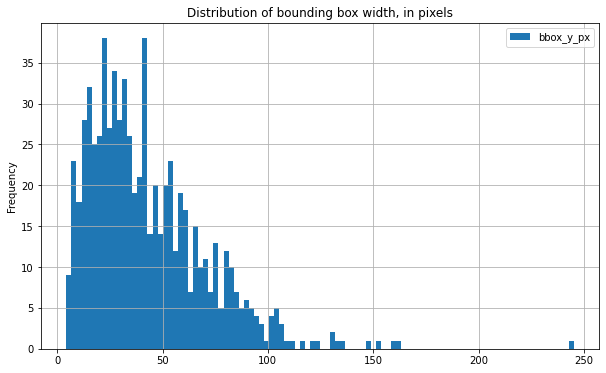

In [ ]:
gt_tps.plot(kind='hist', y='bbox_y_px', bins=100, grid=True, 
         title='Distribution of bounding box width, in pixels',
         figsize=(10,6))

In [ ]:
pd.pivot_table(gt_tps, index='tree_type', values='length', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,length,length,length,length
tree_type,,,,
Fallen,0.421301,11.242332,2.599253,2.322830
Standing,0.729226,4.847981,2.531606,2.470671
All,0.421301,11.242332,2.590690,2.331836


<AxesSubplot:title={'center':'Distribution of groundwood length in meters'}, ylabel='Frequency'>

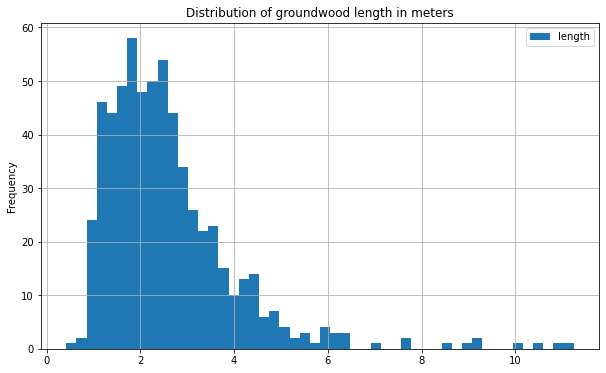

In [ ]:
gt_tps[gt_tps.tree_type =='Fallen'].plot(kind='hist', y='length', bins=50, grid=True, 
                                   title='Distribution of groundwood length in meters',
                                   figsize=(10,6))

<AxesSubplot:title={'center':'Distribution of uprightwood maximum canopy diameter, in meters'}, ylabel='Frequency'>

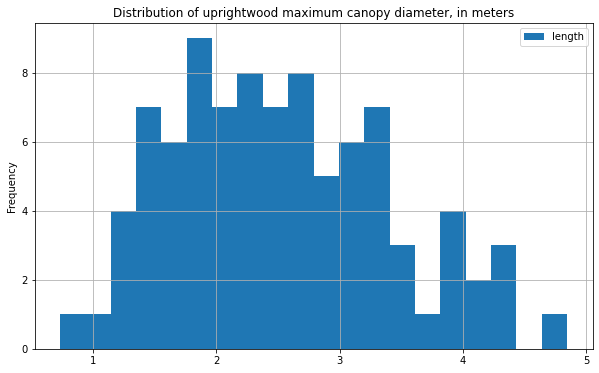

In [ ]:
gt_tps[gt_tps.tree_type =='Standing'].plot(kind='hist', y='length', bins=20, grid=True, 
                                     title='Distribution of uprightwood maximum canopy diameter, in meters',
                                     figsize=(10,6))

# Detections (TP/FP) -comparison

In [ ]:
gts = gpd.read_file(data_path/'dts.geojson')

In [ ]:
fps = gts[gts.det_type == 'FP'].copy()
dt_tps = gts[gts.det_type == 'TP'].copy()

## False positives

In [ ]:
fps['geometry'] = fps.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                        else Polygon(row.geometry.exterior), axis=1)
fps['area'] = fps.geometry.area
fps['pixel_area'] = fps.area / 0.04**2
fps['bbox_area'] = fps.apply(lambda row: box(*row.geometry.bounds).area, axis=1)
fps['bbox_x_px'] = fps.apply(lambda row: (row.geometry.bounds[2] - row.geometry.bounds[0]) / 0.04, axis=1)
fps['bbox_y_px'] = fps.apply(lambda row: (row.geometry.bounds[3] - row.geometry.bounds[1]) / 0.04, axis=1)
fps['bbox_pixel_area'] = fps.bbox_area / 0.04**2
fps['bbox_aspect_ratio'] = fps.bbox_x_px / fps.bbox_y_px
fps['length'] = fps.apply(lambda row: get_len(row.geometry), axis=1)

In [ ]:
pd.pivot_table(fps, index='tree_type', values='area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,area,area,area,area
tree_type,,,,
Fallen,0.002462,2.392145,0.401751,0.286961
Standing,0.489904,7.797723,2.931410,2.236554
All,0.002462,7.797723,0.850045,0.349304


In [ ]:
pd.pivot_table(fps, index='tree_type', values='pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,pixel_area,pixel_area,pixel_area,pixel_area
tree_type,,,,
Fallen,1.538687,1495.090589,251.094601,179.350777
Standing,306.190272,4873.577088,1832.131158,1397.846079
All,1.538687,4873.577088,531.278295,218.315163


In [ ]:
pd.pivot_table(fps, index='tree_type', values='bbox_pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_pixel_area,bbox_pixel_area,bbox_pixel_area,bbox_pixel_area
tree_type,,,,
Fallen,2.051582,14460.577724,1460.173479,586.035795
Standing,374.926864,8096.295174,2684.245548,2120.570847
All,2.051582,14460.577724,1677.097643,835.442279


In [ ]:
pd.pivot_table(fps, index='tree_type', values='bbox_aspect_ratio', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_aspect_ratio,bbox_aspect_ratio,bbox_aspect_ratio,bbox_aspect_ratio
tree_type,,,,
Fallen,0.053191,15.500000,1.769868,1.148148
Standing,0.186441,3.733333,1.056961,1.022543
All,0.053191,15.500000,1.643530,1.100000


In [ ]:
pd.pivot_table(fps, index='tree_type', values='bbox_x_px', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_x_px,bbox_x_px,bbox_x_px,bbox_x_px
tree_type,,,,
Fallen,2.025627,211.962802,37.259041,31.045057
Standing,10.921267,116.448345,49.131500,47.313600
All,2.025627,211.962802,39.363021,33.544626


<AxesSubplot:title={'center':'Distribution of bounding box width, in pixels'}, ylabel='Frequency'>

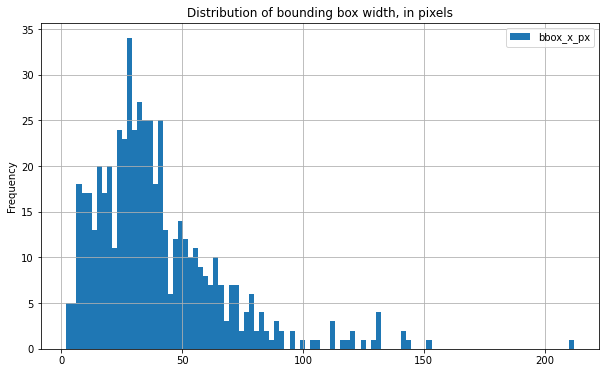

In [ ]:
fps.plot(kind='hist', y='bbox_x_px', bins=100, grid=True, 
         title='Distribution of bounding box width, in pixels',
         figsize=(10,6))

In [ ]:
pd.pivot_table(fps, index='tree_type', values='bbox_y_px', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_y_px,bbox_y_px,bbox_y_px,bbox_y_px
tree_type,,,,
Fallen,1.012813,256.241810,32.80067,25.692461
Standing,14.892637,115.616074,50.40706,49.906434
All,1.012813,256.241810,35.92079,30.298372


<AxesSubplot:title={'center':'Distribution of bounding box width, in pixels'}, ylabel='Frequency'>

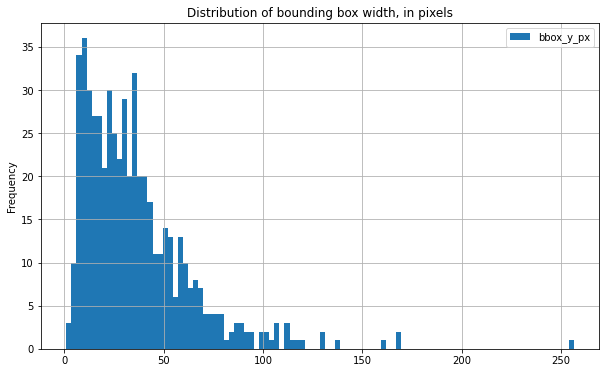

In [ ]:
fps.plot(kind='hist', y='bbox_y_px', bins=100, grid=True, 
         title='Distribution of bounding box width, in pixels',
         figsize=(10,6))

In [ ]:
pd.pivot_table(fps, index='tree_type', values='length', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,length,length,length,length
tree_type,,,,
Fallen,0.081025,10.370546,2.090956,1.662951
Standing,0.873701,4.710142,2.244893,2.226144
All,0.081025,10.370546,2.118236,1.745642


<AxesSubplot:title={'center':'Distribution of groundwood length in meters'}, ylabel='Frequency'>

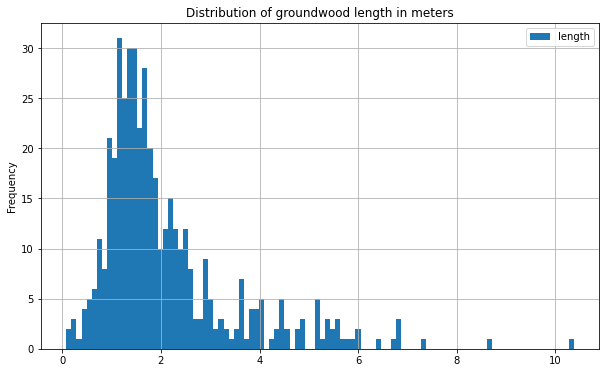

In [ ]:
fps[fps.tree_type =='Fallen'].plot(kind='hist', y='length', bins=100, grid=True, 
                                   title='Distribution of groundwood length in meters',
                                   figsize=(10,6))

<AxesSubplot:title={'center':'Distribution of uprightwood maximum canopy diameter, in meters'}, ylabel='Frequency'>

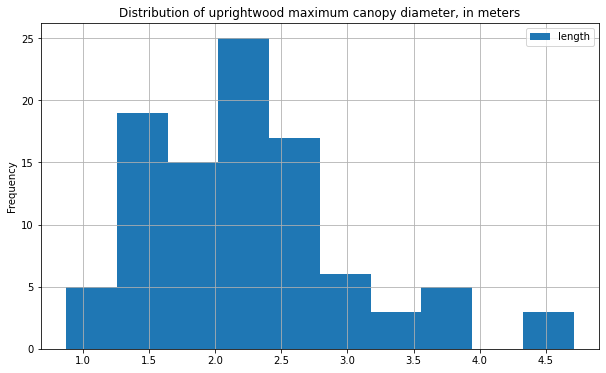

In [ ]:
fps[fps.tree_type =='Standing'].plot(kind='hist', y='length', bins=10, grid=True, 
                                     title='Distribution of uprightwood maximum canopy diameter, in meters',
                                     figsize=(10,6))

## True positives

In [ ]:
dt_tps['geometry'] = dt_tps.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                        else Polygon(row.geometry.exterior), axis=1)
dt_tps['area'] = dt_tps.geometry.area
dt_tps['pixel_area'] = dt_tps.area / 0.04**2
dt_tps['bbox_area'] = dt_tps.apply(lambda row: box(*row.geometry.bounds).area, axis=1)
dt_tps['bbox_x_px'] = dt_tps.apply(lambda row: (row.geometry.bounds[2] - row.geometry.bounds[0]) / 0.04, axis=1)
dt_tps['bbox_y_px'] = dt_tps.apply(lambda row: (row.geometry.bounds[3] - row.geometry.bounds[1]) / 0.04, axis=1)
dt_tps['bbox_pixel_area'] = dt_tps.bbox_area / 0.04**2
dt_tps['bbox_aspect_ratio'] = dt_tps.bbox_x_px / dt_tps.bbox_y_px
dt_tps['length'] = dt_tps.apply(lambda row: get_len(row.geometry), axis=1)

In [ ]:
pd.pivot_table(dt_tps, index='tree_type', values='area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,area,area,area,area
tree_type,,,,
Fallen,0.063260,3.32087,0.477906,0.401855
Standing,0.540797,11.20246,3.782048,3.034464
All,0.063260,11.20246,0.896151,0.449677


In [ ]:
pd.pivot_table(dt_tps, index='tree_type', values='pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,pixel_area,pixel_area,pixel_area,pixel_area
tree_type,,,,
Fallen,39.537392,2075.543440,298.690991,251.159624
Standing,337.998181,7001.537437,2363.779696,1896.539867
All,39.537392,7001.537437,560.094624,281.048212


In [ ]:
pd.pivot_table(dt_tps, index='tree_type', values='bbox_pixel_area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_pixel_area,bbox_pixel_area,bbox_pixel_area,bbox_pixel_area
tree_type,,,,
Fallen,61.884613,20993.870534,1619.928932,1025.936236
Standing,473.915507,10556.304907,3432.256956,2826.570312
All,61.884613,20993.870534,1849.337543,1199.765964


In [ ]:
pd.pivot_table(dt_tps, index='tree_type', values='bbox_aspect_ratio', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_aspect_ratio,bbox_aspect_ratio,bbox_aspect_ratio,bbox_aspect_ratio
tree_type,,,,
Fallen,0.052632,23.666667,1.904946,1.096774
Standing,0.566372,2.000000,1.055034,1.028820
All,0.052632,23.666667,1.797362,1.068182


In [ ]:
pd.pivot_table(dt_tps, index='tree_type', values='bbox_x_px', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_x_px,bbox_x_px,bbox_x_px,bbox_x_px
tree_type,,,,
Fallen,4.964212,246.113675,43.266063,35.708796
Standing,21.269083,103.727098,56.611802,54.256296
All,4.964212,246.113675,44.955397,38.486912


<AxesSubplot:title={'center':'Distribution of bounding box width, in pixels'}, ylabel='Frequency'>

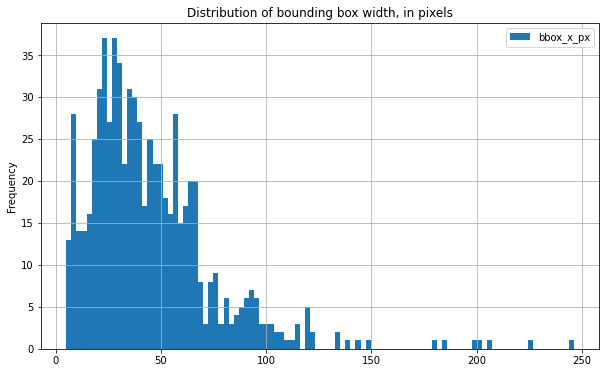

In [ ]:
dt_tps.plot(kind='hist', y='bbox_x_px', bins=100, grid=True, 
         title='Distribution of bounding box width, in pixels',
         figsize=(10,6))

In [ ]:
pd.pivot_table(dt_tps, index='tree_type', values='bbox_y_px', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,bbox_y_px,bbox_y_px,bbox_y_px,bbox_y_px
tree_type,,,,
Fallen,4.964212,181.293613,38.342342,32.410031
Standing,21.528266,122.275573,55.120959,53.350633
All,4.964212,181.293613,40.466217,34.626711


<AxesSubplot:title={'center':'Distribution of bounding box width, in pixels'}, ylabel='Frequency'>

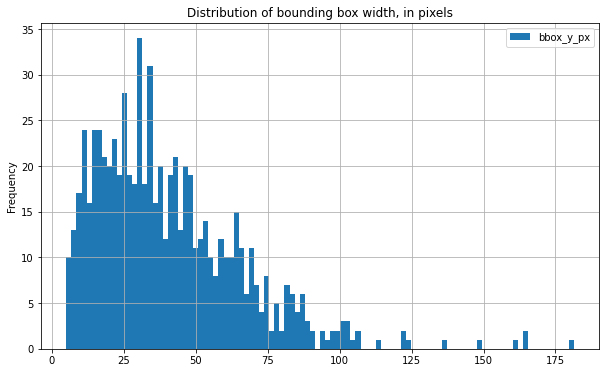

In [ ]:
dt_tps.plot(kind='hist', y='bbox_y_px', bins=100, grid=True, 
         title='Distribution of bounding box width, in pixels',
         figsize=(10,6))

In [ ]:
pd.pivot_table(dt_tps, index='tree_type', values='length', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,length,length,length,length
tree_type,,,,
Fallen,0.440451,9.858085,2.488886,2.229147
Standing,0.887629,4.891023,2.396259,2.305788
All,0.440451,9.858085,2.477161,2.243942


<AxesSubplot:title={'center':'Distribution of groundwood length in meters'}, ylabel='Frequency'>

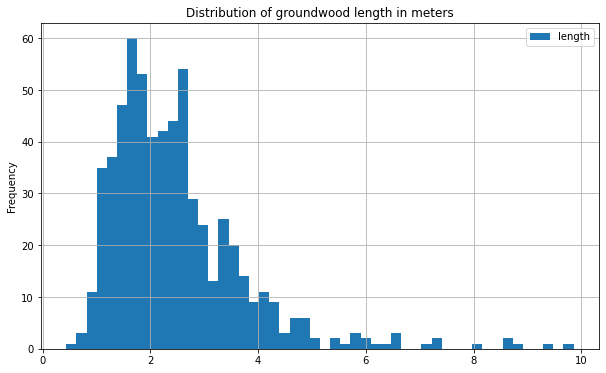

In [ ]:
dt_tps[dt_tps.tree_type =='Fallen'].plot(kind='hist', y='length', bins=50, grid=True, 
                                   title='Distribution of groundwood length in meters',
                                   figsize=(10,6))

<AxesSubplot:title={'center':'Distribution of uprightwood maximum canopy diameter, in meters'}, ylabel='Frequency'>

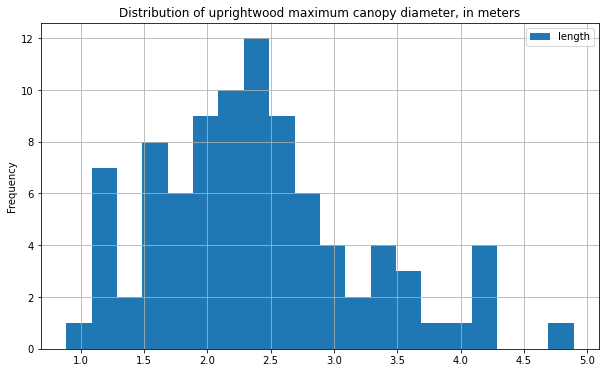

In [ ]:
dt_tps[dt_tps.tree_type =='Standing'].plot(kind='hist', y='length', bins=20, grid=True, 
                                     title='Distribution of uprightwood maximum canopy diameter, in meters',
                                     figsize=(10,6))